# Coursera Capstone Week 3 Toronto

## Basic Instructions

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto based on the postalcode and borough information.. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

## Import all Libraries for this Assignment

In [86]:
import pandas as pd
# for webscraping
import requests
from bs4 import BeautifulSoup
# for getting location data
import geocoder
# for breaking out of loop
import time
# for generating and displaying maps
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# for performing clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print('Libraries imported')

Libraries imported


## Toronto Neighborhoods

### Scrape Relevant Data from the Internet

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')
chars_scraped = len(soup.get_text())
if chars_scraped > 0:
    print(chars_scraped, 'characters scraped from', url)
else:
    print('empty document!!!')

16991 characters scraped from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M


### Get Relevant Data from Scraped Website

Postal Codes and Neighborhood Names are stored in a table.

In [3]:
tables = soup.find_all('table')
print('There are', len(tables), 'tables on this webpage.')
# print first 250 characters of each table to identify the correct table
for index, table in enumerate(tables):
    print(' ', '---------- table index ' + str(index) + '----------',
          ' ', str(table)[:250], sep='\n')

There are 3 tables on this webpage.
 
---------- table index 0----------
 
<table cellpadding="2" cellspacing="0" rules="all" style="width:100%; border-collapse:collapse; border:1px solid #ccc;">

<tbody><tr>
<td style="width:11%; vertical-align:top; color:#ccc;">
<p><b>M1A</b><br/><span style="font-size:85%;"><i>Not assign
 
---------- table index 1----------
 
<table class="navbox">
<tbody><tr>
<td style="width:36px; text-align:center"><a class="image" href="/wiki/File:Flag_of_Canada.svg" title="Flag of Canada"><img alt="Flag of Canada" data-file-height="600" data-file-width="1200" decoding="async" height=
 
---------- table index 2----------
 
<table cellspacing="0" style="background-color: #F8F8F8;" width="100%">
<tbody><tr>
<td style="text-align:center; border:1px solid #aaa;"><a href="/wiki/Newfoundland_and_Labrador" title="Newfoundland and Labrador">NL</a>
</td>
<td style="text-align:c


For getting postal codes, boroughs and neighborhood names the first table is needed as can be seen by `<p><b>M1A</b><br/><span style="font-size:85%;"><i>Not assign`. M1A is the postal code in this example.

In [4]:
all_table_rows = []

for row in tables[0].tbody.find_all('tr'):
    for cells in row.find_all('td'):
        all_table_rows.append([cells.find('b').get_text(), cells.find('span').get_text()])

print(len(all_table_rows), 'cells were found in this table')
print('---------- 5. element of 1. row ----------')
print(all_table_rows[4])

180 cells were found in this table
---------- 5. element of 1. row ----------
['M5A', 'Downtown Toronto(Regent Park / Harbourfront)']


In [5]:
df = pd.DataFrame(all_table_rows)
display(df.head())

,0,1
0,M1A,Not assigned
1,M2A,Not assigned
2,M3A,North York(Parkwoods)
3,M4A,North York(Victoria Village)
4,M5A,Downtown Toronto(Regent Park / Harbourfront)


### Clean the DataFrame

In [6]:
# get a description of the dataframe
display(df.describe())
# delete all rows without Borough/Neighborhood
df = df[df[1] != 'Not assigned']
df[['Borough', 'Neighborhood', 'Empty']] = df[1].str.split('(', expand=True)
df.drop(columns=[1, 'Empty'], inplace=True)
df.rename(columns = {0:'PostalCode'}, inplace = True)
df['Neighborhood'] = df['Neighborhood'].str.replace(')', '')
df['Neighborhood'] = df['Neighborhood'].str.replace(' / ', ', ')
df['Borough'] = df['Borough'].str.replace('Downtown TorontoStn A PO Boxes25 The Esplanade', 'Downtown Toronto')
df['Borough'] = df['Borough'].str.replace('MississaugaCanada Post Gateway Processing Centre', 'Mississauga')
df['Borough'] = df['Borough'].str.replace('East TorontoBusiness reply mail Processing Centre969 Eastern', 'East Toronto')
df['Borough'] = df['Borough'].str.replace('EtobicokeNorthwest', 'Etobicoke Northwest')
df['Borough'] = df['Borough'].str.replace('East YorkEast Toronto', 'East York/East Toronto')
display(df.head())

,0,1
count,180,180
unique,180,104
top,M9X,Not assigned
freq,1,77


,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Queen's Park,Ontario Provincial Government


### Check for Null-Values

In [7]:
display(df.isna().sum())

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

## Get Latitudes and Longitudes per Postal Code

### Using Geocoder (or at least trying to)

The developers of this course state that this package can be very unreliable. I've been trying to break out of the loop after 30 seconds but the execution usually gets stuck during calling to geocoder.google without ever reaching the next line but one. So I finally commented this part out.

In [19]:
# pc_lat_lng = []

# print('Working', end=': ')

# for postal_code in df['PostalCode']:

#     print(postal_code, end='')
    
#     lat_lng_coords = None
#     time_now = time.time()
#     print('starting at', time_now)
#     while(lat_lng_coords is None):
#         g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#         lat_lng_coords = g.latlng
#         elapsed = time.time() - time_now
#         if elapsed > 30:
#             break
            
#     if elapsed <= 30:
#         pc_lat_lng.append([postal_code, lat_lng_coords[0], lat_lng_coords[1]])
#         print(': done', end=' - ')
#     else:
#         print(': taking too long', end=' - ')
    
# print(pc_lat_lng[:5])

### Reading .csv-File Provided in Case Geocoder Doesn't Work

In [20]:
df_latlng = pd.read_csv('Geospatial_Coordinates.csv')
print('This dataframe has', df_latlng.shape[0], 'rows')
display(df_latlng.head(2))

This dataframe has 103 rows


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497


### Merge with Existing DataFrame

In [120]:
df_complete = df.merge(df_latlng, left_on='PostalCode', right_on='Postal Code')
df_complete.drop(columns='Postal Code', inplace=True)
display(df_complete.head())

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## Explore Neighbourhoods

### Visualize all Neighborhoods

This is merely meant to get any idea of how all neighborhoods are distributed - I'm not familiar with them and I guess a lot of other users aren't either.

In [22]:
# use mean values of latitude and longitude to define center of map
latitude = df_complete['Latitude'].mean()
longitude = df_complete['Longitude'].mean()

# generate basic map
nbh_map = folium.Map(location=[latitude, longitude], zoom_start=10)

colors = ['lightblue', 'mediumblue', 'blue', 'darkblue', 'navy',
          'lightgreen', 'palegreen', 'green', 'darkgreen', 'forestgreen',
          'coral', 'red', 'darkred']

for i, borough in enumerate(df_complete['Borough'].unique()):
    color = colors[i]
    df_borough = df_complete[df_complete['Borough'] == borough]
    # add markers for each neighborhood
    for lat, lng, borough, postal in zip(df_borough['Latitude'], df_borough['Longitude'],
                                                df_borough['Borough'], df_borough['PostalCode']):
            label= postal + ' ' + borough
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                color='black',
                weight=1,
                popup=label,
                fill = True,
                fill_color=color,
                fill_opacity=1
            ).add_to(nbh_map)

# display map
nbh_map.save('nbh_map.html')
print('Each borough is shown in a different colour. This does not represent clustering.')
display(nbh_map)

Each borough is shown in a different colour. This does not represent clustering.


### Define Foursquare Credentials

In [23]:
CLIENT_ID = 'SVG23QBUTKWRZPL3WSBLG4MRQTDCSNAGTBN4Q3LVQXYCS1FY' # your Foursquare ID
CLIENT_SECRET = '01B1S5KEKFASZ12EGGFV2ZFYV1PFTQJRDO2FRJWOE1PJ1A2R' # your Foursquare Secret
ACCESS_TOKEN = '4NL4SNK4BUYDOKQGIPB242F5YSAIQTLTGRJDCW5ETB2213BE' # your FourSquare Access Token

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Defining Function to Get Nearby Venues

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    print('Please be patient; this will take a little time.')
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print('\nBuilding DataFrame')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Returning Result')
    
    return(nearby_venues)

### Get Venues for all of Toronto

In [73]:
toronto_venues = getNearbyVenues(names=df_complete['Neighborhood'],
                                 latitudes=df_complete['Latitude'],
                                 longitudes=df_complete['Longitude'],
                                 radius=1500
                                  )

print('Overall', toronto_venues.shape[0], 'venues were returned')
display(toronto_venues.head())

Please be patient; this will take a little time.
.......................................................................................................
Building DataFrame
Returning Result
Overall 6826 venues were returned


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
2,Parkwoods,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
3,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
4,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store


### How Many Venues were Returned per Neighborhood?

In [74]:
display(toronto_venues['Neighborhood'].value_counts().to_frame(name='count'))

First Canadian Place, Underground city    100
The Beaches                               100
Studio District                           100
Berczy Park                               100
Dufferin, Dovercourt Village              100
                                         ... 
Bayview Village                            16
Birch Cliff, Cliffside West                12
Rouge Hill, Port Union, Highland Creek     10
DownsviewWest                               6
Upper Rouge                                 3
Name: Neighborhood, Length: 103, dtype: int64

### And How Many Unique Venues are There?

In [75]:
print('There are', toronto_venues['Venue Category'].nunique(), 'unique venues.')

There are 337 unique venues.


## Cluster Neighborhoods

### One-Hot Encoding of Categories

In [76]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print('After one-hot encoding there are', toronto_onehot.shape[0], 
      'rows and', toronto_onehot.shape[1], 'columns')
display(toronto_onehot.head())

After one-hot encoding there are 6826 rows and 337 columns


,Zoo Exhibit,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group by Neighborhoods

In [77]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print('There are', toronto_grouped['Neighborhood'].nunique(), 'Neighborhoods with Venues.')
display(toronto_grouped)

There are 103 Neighborhoods with Venues.


,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.015873,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.000000,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.013514,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,WillowdaleWest,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.024390,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
99,Woburn,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.030303,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
100,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
101,York Mills West,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.012987,0.0


### Most Common Venues per Neighborhood

#### Defining Function

In [90]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [91]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

display(neighborhoods_venues_sorted.head())

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Breakfast Spot,Bakery,Department Store,Caribbean Restaurant,Asian Restaurant,Cantonese Restaurant,Coffee Shop,Gym / Fitness Center
1,"Alderwood, Long Branch",Pizza Place,Park,Café,Coffee Shop,Burger Joint,Bank,Grocery Store,Restaurant,Convenience Store,Bar
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Coffee Shop,Gas Station,Bank,Pizza Place,Baseball Field,Dog Run,Fried Chicken Joint,French Restaurant,Sushi Restaurant
3,Bayview Village,Park,Gas Station,Trail,Bank,Skating Rink,Playground,Café,Shopping Mall,Grocery Store,Chinese Restaurant
4,"Bedford Park, Lawrence Manor East",Bakery,Italian Restaurant,Sushi Restaurant,Coffee Shop,Bagel Shop,Pharmacy,Café,Pizza Place,Pub,Sandwich Place


### Apply Machine Learning for Clustering
#### Finding Optimal Number of Clusters

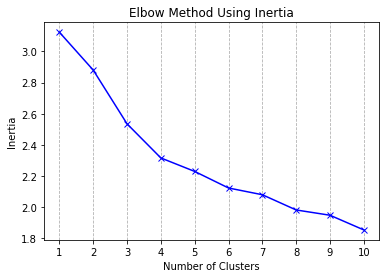

In [125]:
from sklearn import metrics
from scipy.spatial.distance import cdist

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

inertia, distortions = [], []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(toronto_grouped_clustering)
    inertia.append(kmeans.inertia_)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, 
                                        kmeans.cluster_centers_, 'euclidean'), 
                                  axis=1)) / toronto_grouped_clustering.shape[0])
    
plt.plot(range(1, 11), inertia, 'bx-')
plt.xticks(range(1, 11))
plt.grid(axis='x', ls='dashed')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method Using Inertia')
plt.show()

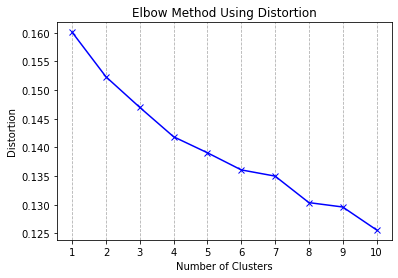

In [123]:
plt.plot(range(1, 11), distortions, 'bx-')
plt.xticks(range(1, 11))
plt.grid(axis='x', ls='dashed')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method Using Distortion')
plt.show()

From these plots it isn't straight-forward to choose the optimal number but 4 seems a good choice for both of them since both curves flatten out some at this point.

#### Running Algorithm with Optimal Number

In [93]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print('First 10 labels:', kmeans.labels_[0:10])

First 10 labels: [2 1 0 0 1 1 0 1 1 1]


### Merge with Overview of Top 10 Venues per Neighborhood

In [94]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_complete

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

display(toronto_merged.head())

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Pharmacy,Coffee Shop,Park,Supermarket,Intersection,Gas Station,Cosmetics Shop,Pizza Place,Bank,Discount Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Coffee Shop,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Shoe Store,Thrift / Vintage Store,Grocery Store,Gym / Fitness Center,Indian Restaurant,Shopping Mall
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Café,Park,Restaurant,Diner,Japanese Restaurant,Bakery,Farmers Market,Pub,Gastropub
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Sandwich Place,Vietnamese Restaurant,Furniture / Home Store,Turkish Restaurant,Food Court,Men's Store
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,Coffee Shop,Pizza Place,Café,Park,Japanese Restaurant,Shopping Mall,Bubble Tea Shop,Beer Bar,Restaurant,Ramen Restaurant


### How many Neighborhoods are there per Cluster?

In [95]:
display(toronto_merged['Cluster Labels'].value_counts())

1    56
2    36
0    10
3     1
Name: Cluster Labels, dtype: int64

### Display Clusters on Map

In [106]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

Looking at the distribution of clusters it's easy to say that
- all neighborhoods in Central Toronto are similar to each other
- most of the suburbs are also similar 
- most neighborshoods on the coast have been grouped together but also a couple inland.
Let's have a look at the third cluster which is actually cluster 0.

In [98]:
display(toronto_merged[toronto_merged['Cluster Labels'] == 0])

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,0,Pharmacy,Park,Bank,Playground,Grocery Store,Bakery,Convenience Store,Café,Bus Line,Supermarket
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,0,Park,Hotel,Sandwich Place,Pharmacy,Farmers Market,Bank,Grocery Store,Gym,Gym / Fitness Center,Restaurant
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0,Hotel,Italian Restaurant,Burger Joint,Grocery Store,Gym,Gym / Fitness Center,Park,Breakfast Spot,Pizza Place,Cupcake Shop
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,Park,Coffee Shop,Gas Station,Bank,Pizza Place,Baseball Field,Dog Run,Fried Chicken Joint,French Restaurant,Sushi Restaurant
39,M2K,North York,Bayview Village,43.786947,-79.385975,0,Park,Gas Station,Trail,Bank,Skating Rink,Playground,Café,Shopping Mall,Grocery Store,Chinese Restaurant
46,M3L,North York,DownsviewWest,43.739015,-79.506944,0,Park,Bank,Plaza,Tea Room,Pizza Place,Zoo,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
50,M9L,North York,Humber Summit,43.756303,-79.565963,0,Park,Vietnamese Restaurant,Electronics Store,Asian Restaurant,Bakery,Mexican Restaurant,Shopping Mall,Italian Restaurant,Skating Rink,Bank
51,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0,Park,Harbor / Marina,Coffee Shop,Ice Cream Shop,Pizza Place,Pub,Sandwich Place,Fast Food Restaurant,Beach,Grocery Store
58,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0,Park,Restaurant,General Entertainment,Golf Course,Café,Diner,Gym,Thai Restaurant,College Stadium,Filipino Restaurant
88,M8V,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,0,Park,Bakery,Grocery Store,Breakfast Spot,Café,Indian Restaurant,Beer Store,Thai Restaurant,Mexican Restaurant,Bar


Amazingly enough the most common venue of all of them has nothing at all to do with water (coast, ocean, lake, river...) but is a park!

### Print Top 5 Most Common Venues per Cluster

In [105]:
for cluster in toronto_merged['Cluster Labels'].unique():
    df_cluster = toronto_merged[toronto_merged['Cluster Labels'] == cluster]
    print('=========================================',
          'Cluster ' + str(cluster),
          '=========================================',
          df_cluster['1st Most Common Venue'].value_counts().head(),
          ' ', sep='\n')

Cluster 2
Coffee Shop           13
Pharmacy               3
Pizza Place            3
Chinese Restaurant     3
Clothing Store         2
Name: 1st Most Common Venue, dtype: int64
 
Cluster 1
Coffee Shop           32
Café                   5
Park                   5
Italian Restaurant     4
Greek Restaurant       2
Name: 1st Most Common Venue, dtype: int64
 
Cluster 0
Park        8
Hotel       1
Pharmacy    1
Name: 1st Most Common Venue, dtype: int64
 
Cluster 3
Farm    1
Name: 1st Most Common Venue, dtype: int64
 
